# Based on Riess et. al 2009a and Riess et. al 2016

In [1]:
import numpy as np
from numpy import power as pw
import matplotlib.pyplot as plt
from iminuit import Minuit
import matplotlib.gridspec as gridspec
from astropy.io.ascii import read as aread
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Riess et. al 2009

### Data load

In [ ]:
dtypes_ceph = {'names': ('Field', 'RAdeg', 'DEdeg', 'Id', 'Per', 'F555W-F814W', 'F160W', 'sigma_tot','Offset','Bias','Phase','[O/H]','Flag','Src'),'formats': ('a5', 'f', 'f', 'i', 'f', 'f', 'f', 'f', 'f','f','f','f','a8','a5') }
data_cephe_R09 = np.loadtxt("./Cepheids data/R09_cepheids.dat",dtype=dtypes_ceph)

dtypes_sn={'names': ('Field', 'SN', 'Filters', 'mag_5a', 'sigma_mag_5a', 'mu_i-mu4258', 'sigma_diff_mu'),'formats': ('a8', 'a8', 'a5', 'f', 'f', 'f', 'f') }
data_sn_R09=np.loadtxt("./Cepheids data/R09_SN.txt",dtype=dtypes_sn)

sn_host=data_sn_R09['Field']

In [ ]:
#Selection 2.7 sigma
s1 = data_cephe_R09['Flag'] == b'None'
s2 = data_cephe_R09['Flag'] == b'<P'
data_cephe_R09 = data_cephe_R09[s1+s2]
print(f'nbr cepheids = {len(data_cephe_R09)}')

### b_H slope

In [ ]:
#b_H, Zp4258
n_params = 2
n_sn = len(sn_host)
n_ceph_by_host = [len(data_cephe_R09[data_cephe_R09['Field']== host]) for host in sn_host]
n_ceph = np.sum(n_ceph_by_host)
n_ceph_cumsum = np.concatenate(([0],np.cumsum(n_ceph_by_host)))
L_ceph = np.zeros((n_ceph,n_sn+n_params))
y_ceph=np.zeros(n_ceph)
cov_ceph=np.zeros(n_ceph)

for i,host in enumerate(sn_host):
    selec_ceph = data_cephe_R09[data_cephe_R09['Field'] == host]
    L_ceph[n_ceph_cumsum[i]:n_ceph_cumsum[i+1],i] = 1
    L_ceph[n_ceph_cumsum[i]:n_ceph_cumsum[i+1],-2] = 1
    L_ceph[n_ceph_cumsum[i]:n_ceph_cumsum[i+1],-1] = np.log10(selec_ceph['Per'])
    y_ceph[n_ceph_cumsum[i]:n_ceph_cumsum[i+1]] = selec_ceph['F160W'] 
    
    cov_ceph[n_ceph_cumsum[i]:n_ceph_cumsum[i+1]] = pw(selec_ceph['sigma_tot'],2)
    

selec_ceph = data_cephe_R09[[i not in sn_host for i in data_cephe_R09['Field']]]
n_4258 = len(selec_ceph)
L_4258 = np.zeros((n_4258,n_sn+n_params))
L_4258[:,-2] = 1
L_4258[:,-1] = np.log10(selec_ceph['Per']) 
y_4258 = selec_ceph['F160W'] 
cov_4258 = pw(selec_ceph['sigma_tot'],2)

In [ ]:
L = np.concatenate((L_ceph,L_4258),axis=0)
y = np.concatenate((y_ceph,y_4258))
C = np.diag(np.concatenate((cov_ceph,cov_4258)))

In [ ]:
print(y)
print(10**L[:,-1])
print(C)

#### Fisher solution

In [ ]:
C_inv = np.linalg.inv(C)
cov_res = np.linalg.inv(L.T @ C_inv @ L)
res = cov_res @ L.T @ C_inv @ y

chi2 = ((y-L @ res).T @ C_inv @ (y-L @ res))/(np.size(y)-np.size(res))

In [ ]:
print(f'b_h = {res[-1]} +/- {np.sqrt(cov_res[-1,-1])}')
print(f'chi2 = {chi2}')

#### Minuit $\chi^2$ minimization

In [ ]:
def chi2_bh(q):
    return (y-L @ q).T @ C_inv @ (y-L.dot(q))

In [ ]:
x0 = [1.40404562,2.20035556,2.46433945,2.77387999,2.87413743,3.12362051,26.81027181,-3.09]
fix = [False, False, False, False, False, False, False, False]
names = np.concatenate((np.array(["mu_{}_muN4258".format(n.decode('utf-8')) for n in sn_host]),np.array(['zp_w4258','b_H'])))
chimin_bh = Minuit.from_array_func(chi2_bh,x0, errordef = 1,fix=fix ,error=0.001,name=names)

In [ ]:
chimin_bh.migrad()
chimin_bh.hesse()
chimin_bh.minos()
print(chimin_bh.params)
print(f'chi2={chimin_bh.fval/(np.size(y)-np.size(res))}')

#### Fit results plot 

In [ ]:
for i,host in enumerate(sn_host):
    cephe_list = data_cephe_R09[data_cephe_R09['Field']== host]
    p = np.linspace(np.min(cephe_list['Per'])-1,np.max(cephe_list['Per'])+1,1000)
    
    fig=plt.figure(figsize = (15, 10))
    plt.title(host)
    plt.rcParams.update({'font.size': 15})
    gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1]) 
    ax0 = plt.subplot(gs[0])
    ax0.set_xlabel('logP')
    ax0.set_ylabel('$m_H$')
    ax0.set_xscale('log')
    ax0.errorbar(cephe_list['Per'], cephe_list['F160W'],yerr=cephe_list['sigma_tot'],fmt='.')
    ax0.plot(p,res[i]+res[-2]+res[-1]*np.log10(p), color='g', label='Current_fit')
    ax0.plot(p,res[i]+res[-2]-3.09*np.log10(p), color='r', label='R09 fit')
    ax0.invert_yaxis()
    ax0.tick_params(axis='x',which='both', direction='in')
    ax0.grid()
    ax0.legend()
    ax1 = plt.subplot(gs[1],sharex=ax0)
    ax1.set_xlabel('logP')
    ax1.set_ylabel('$m-m_{fit}$')
    ax1.errorbar(cephe_list['Per'],cephe_list['F160W']-(res[i]+res[-2]+res[-1]*np.log10(cephe_list['Per'])),yerr=cephe_list['sigma_tot'],fmt ='.',elinewidth=1.5,ms=2,color='g')
    ax1.errorbar(cephe_list['Per'],cephe_list['F160W']-(res[i]+res[-2]-3.09*np.log10(cephe_list['Per'])),yerr=cephe_list['sigma_tot'],fmt ='.',elinewidth=1.5, ms=2, color='r')
    ax1.grid()
    ax1.set_ylim(-1.2,1.2)
    ax1.set_yticks(np.arange(-1.2,1.2,step=0.4))
    plt.subplots_adjust(hspace=.0)
    plt.setp(ax0.get_xticklabels(), visible=False)
    plt.show()
    print("mean residual of current fit=",np.mean(cephe_list['F160W']-(res[i]+res[-2]+res[-1]*np.log10(cephe_list['Per']))))
    print("mean residual of R09 fit=",np.mean(cephe_list['F160W']-(res[i]+res[-2]-3.09*np.log10(cephe_list['Per']))))


### b_w slope

In [ ]:
R=0.479 #Cardelli et al. (1989) Rv=3.1 R=0.479

In [ ]:
#b_w, Zp4258
n_params = 2
n_ceph_by_host = [len(data_cephe_R09[data_cephe_R09['Field']== host]) for host in sn_host]
n_ceph = np.sum(n_ceph_by_host)
n_ceph_cumsum = np.concatenate(([0],np.cumsum(n_ceph_by_host)))
L_ceph = np.zeros((n_ceph,n_sn+n_params))
y_ceph=np.zeros(n_ceph, dtype='f4')
cov_ceph=np.zeros(n_ceph)

for i,host in enumerate(sn_host):
    selec_ceph = data_cephe_R09[data_cephe_R09['Field'] == host]
    L_ceph[n_ceph_cumsum[i]:n_ceph_cumsum[i+1],i] = 1
    L_ceph[n_ceph_cumsum[i]:n_ceph_cumsum[i+1],-2] = 1
    L_ceph[n_ceph_cumsum[i]:n_ceph_cumsum[i+1],-1] = np.log10(selec_ceph['Per'])
     
    y_ceph[n_ceph_cumsum[i]:n_ceph_cumsum[i+1]] = selec_ceph['F160W']-R*selec_ceph['F555W-F814W']
    
    cov_ceph[n_ceph_cumsum[i]:n_ceph_cumsum[i+1]] = pw(selec_ceph['sigma_tot'],2)+pw(0.02*R,2)
    

selec_ceph = data_cephe_R09[[i not in sn_host for i in data_cephe_R09['Field']]]
n_4258 = len(selec_ceph)
L_4258 = np.zeros((n_4258,n_sn+n_params))
L_4258[:,-2] = 1
L_4258[:,-1] = np.log10(selec_ceph['Per'])

y_4258 = selec_ceph['F160W']-R*selec_ceph['F555W-F814W']
cov_4258 = pw(selec_ceph['sigma_tot'],2)+pw(0.02*R,2)

In [ ]:
L = np.concatenate((L_ceph,L_4258),axis=0)
y = np.concatenate((y_ceph,y_4258))
C = np.diag(np.concatenate((cov_ceph,cov_4258)))

#### Fisher solution

In [ ]:
C_inv = np.linalg.inv(C)
cov_res = np.linalg.inv(L.T @ C_inv @ L)
res = cov_res @ L.T @ C_inv @ y

chi2 = ((y-L @ res).T @ C_inv @ (y-L @ res))/(np.size(y)-np.size(res))

In [ ]:
print(res)
print(np.sqrt(cov_res[-1,-1]))

#### Minuit $\chi^2$ minimization

In [ ]:
def chi2_bw(q):
    return (y-L @ q).T @ C_inv @ (y-L.dot(q))

In [ ]:
x0 = [1.40404562,2.20035556,2.46433945,2.77387999,2.87413743,3.12362051,26.81027181,-3.20]
fix = [False, False, False, False, False, False, False, False]
names = np.concatenate((np.array(["mu_{}_muN4258".format(n.decode('utf-8')) for n in sn_host]),np.array(['zp_w4258','b_H'])))
chimin_bw = Minuit.from_array_func(chi2_bw,x0, errordef = 1,fix=fix ,error=0.001,name=names)

In [ ]:
chimin_bw.migrad()
chimin_bw.hesse()
chimin_bw.minos()
print(chimin_bw.params)
print(f'chi2={chimin_bw.fval/(np.size(y)-np.size(res))}')

#### Fit result plot

In [ ]:
for i,host in enumerate(sn_host):
    cephe_list = data_cephe_R09[data_cephe_R09['Field']== host]
    p = np.linspace(np.min(cephe_list['Per'])-1,np.max(cephe_list['Per'])+1,1000)
    
    fig=plt.figure(figsize = (15, 10))
    plt.title(host)
    plt.rcParams.update({'font.size': 20})
    gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1]) 
    ax0 = plt.subplot(gs[0])
    ax0.set_xlabel('logP')
    ax0.set_ylabel('mw')
    ax0.set_xscale('log')
    ax0.errorbar(cephe_list['Per'], cephe_list['F160W']-R*cephe_list['F555W-F814W'],yerr=cephe_list['sigma_tot'],fmt='.')
    ax0.plot(p,res[i]+res[-2]+res[-1]*np.log10(p), color='g', label='Current_fit')
    ax0.plot(p,res[i]+res[-2]-3.09*np.log10(p), color='r', label='R09 fit')
    ax0.invert_yaxis()
    ax0.tick_params(axis='x',which='both', direction='in')
    ax0.grid()
    ax0.legend()
    ax1 = plt.subplot(gs[1],sharex=ax0)
    ax1.set_xlabel('logP')
    ax1.set_ylabel('$m-m_{fit}$')
    ax1.errorbar(cephe_list['Per'],cephe_list['F160W']-R*cephe_list['F555W-F814W']-(res[i]+res[-2]+res[-1]*np.log10(cephe_list['Per'])),yerr=cephe_list['sigma_tot'],fmt ='.',elinewidth=1.5,ms=2,color='g')
    ax1.errorbar(cephe_list['Per'],cephe_list['F160W']-R*cephe_list['F555W-F814W']-(res[i]+res[-2]-3.09*np.log10(cephe_list['Per'])),yerr=cephe_list['sigma_tot'],fmt ='.',elinewidth=1.5, ms=2, color='r')
    ax1.grid()
    ax1.set_ylim(-1.2,1.2)
    ax1.set_yticks(np.arange(-1.2,1.2,step=0.4))
    plt.subplots_adjust(hspace=.0)
    plt.setp(ax0.get_xticklabels(), visible=False)
    plt.show()
    print("mean residual of current fit=",np.mean(cephe_list['F160W']-R*cephe_list['F555W-F814W']-(res[i]+res[-2]+res[-1]*np.log10(cephe_list['Per']))))
    print("mean residual of R09 fit=",np.mean(cephe_list['F160W']-R*cephe_list['F555W-F814W']-(res[i]+res[-2]-3.09*np.log10(cephe_list['Per']))))


### H0 fit

In [ ]:
R=0.479 #Cardelli et al. (1989) Rv=3.1 R=0.479

av=0.698 #240 SNe Ia from Hicken et al. (2009)
sigma_av=0.00225

mu_N4258 = 5*np.log10(7.2)+25
sigma_mu_N4258 = 5/(np.log(10)*mu_N4258)*3/100*7.2
#sigma_mu_N4258 = 5/(np.log(10)*mu_N4258)*np.sqrt(0.5**2+0.2**2)

In [ ]:
#res = mu_i-mu_4258, zpw4258, bw, m_4258, Zw
n_params = 3

n_ceph_by_host = [len(data_cephe_R09[data_cephe_R09['Field']== host]) for host in sn_host]
n_ceph = np.sum(n_ceph_by_host)
n_ceph_cumsum = np.concatenate(([0],np.cumsum(n_ceph_by_host)))
n_sn = len(sn_host)
L_ceph = np.zeros((n_ceph,n_sn+n_params))
L_sn = np.zeros((n_sn,n_sn+n_params))
y_ceph=np.zeros(n_ceph)
y_sn = np.zeros(n_sn)
cov_ceph=np.zeros(n_ceph)
cov_sn=np.zeros(n_sn)

for i,host in enumerate(sn_host):
    selec_ceph = data_cephe_R09[data_cephe_R09['Field'] == host]
    L_ceph[n_ceph_cumsum[i]:n_ceph_cumsum[i+1],i] = 1
    L_ceph[n_ceph_cumsum[i]:n_ceph_cumsum[i+1],-4+1] = 1
    L_ceph[n_ceph_cumsum[i]:n_ceph_cumsum[i+1],-3+1] = np.log10(selec_ceph['Per'])
    #L_ceph[n_ceph_cumsum[i]:n_ceph_cumsum[i+1],-1] = selec_ceph['[O/H]'] - 8.9
 
    L_sn[i,i] = 1
    L_sn[i,-2+1] = 1
    
    y_ceph[n_ceph_cumsum[i]:n_ceph_cumsum[i+1]] = selec_ceph['F160W']-R*selec_ceph['F555W-F814W']
    y_sn[i] = data_sn_R09[data_sn_R09['Field'] == host]['mag_5a'] - 5*av
    
    cov_ceph[n_ceph_cumsum[i]:n_ceph_cumsum[i+1]] = pw(selec_ceph['sigma_tot'],2)
    cov_sn[i] = pw(data_sn_R09[data_sn_R09['Field'] == host]['sigma_mag_5a'],2)-25*pw(sigma_av,2)
    
selec_ceph = data_cephe_R09[[i not in sn_host for i in data_cephe_R09['Field']]]
n_4258 = len(selec_ceph)
L_4258 = np.zeros((n_4258,n_sn+n_params))
L_4258[:,-4+1] = 1
L_4258[:,-3+1] = np.log10(selec_ceph['Per'])
#L_4258[:,-1+1] = selec_ceph['[O/H]'] - 8.9

y_4258 = selec_ceph['F160W']-R*selec_ceph['F555W-F814W']
cov_4258 = pw(selec_ceph['sigma_tot'],2)

In [ ]:
L = np.concatenate((L_ceph,L_4258,L_sn),axis=0)
y = np.concatenate((y_ceph,y_4258,y_sn))
C = np.diag(np.concatenate((cov_ceph,cov_4258,cov_sn)))
np.savetxt('L.txt', L, fmt='%1.2f')


In [ ]:
C_inv = np.linalg.inv(C)
cov_res = np.linalg.inv(L.T @ C_inv @ L)
res = cov_res @ L.T @ C_inv @ y

chi2 = ((y-L @ res).T @ C_inv @ (y-L @ res))/(np.size(y)-np.size(res))


In [ ]:
print(res)
print(np.sqrt(cov_res[-1,-1]))
print(chi2)

In [ ]:
log_H0 = (res[-1]-mu_N4258+5*av+25)/5
sigma_log_H0 = np.sqrt(25*pw(sigma_av,2)+pw(sigma_mu_N4258,2)+cov_res[-1,-1])/5  
H0 = pw(10,log_H0)
sigma_H0 = np.log(10)*pw(10,log_H0)*sigma_log_H0
print(f"logH0 = {log_H0} +/- {sigma_log_H0}")
print(f"H0 = {H0} +/- {sigma_H0}")

## Riess et al. 2016

### Data load and visualisation

In [179]:
data_cephe = aread('./Cepheids data/table4.dat',readme='./Cepheids data/zzz_ReadMe')

data_names_sn=['Gal', 'SN_id', 'mag+5a', 'sig_mag+5a', 'mu_i', 'sig_mu_i', 'M0', 'sigM0']
data_sn_R16=aread("./Cepheids data/R16_SN.txt",names=data_names_sn)

In [180]:
data_cephe

Gal,RAdeg,DEdeg,ID,Per,V-I,F160W,sigTot,[O/H]
,deg,deg,,d,mag,mag,mag,[-]
str5,float64,float64,str8,float64,float64,float64,float64,float64
M101,210.87979,54.33376,115287,17.95,0.96,22.47,0.3,9.134
M101,210.89127,54.3562,136682,5.358,1.06,24.41,0.57,9.118
M101,210.89227,54.36125,148312,11.86,1.07,22.94,0.32,9.113
M101,210.89351,54.36826,164932,14.92,1.13,23.03,0.32,9.105
M101,210.87982,54.33565,121146,11.86,0.96,23.14,0.45,9.136
M101,210.89249,54.36142,147959,7.762,1.01,23.79,0.42,9.113
M101,210.87549,54.34114,157556,25.57,1.14,22.75,0.19,9.148
M101,210.88855,54.34493,112715,8.173,0.97,23.8,0.42,9.124


In [181]:
data_sn_R16

Gal,SN_id,mag+5a,sig_mag+5a,mu_i,sig_mu_i,M0,sigM0
str5,str6,float64,float64,float64,float64,float64,float64
M101,2011fe,13.31,0.117,29.135,0.045,-19.389,0.125
N1015,2009ig,17.015,0.123,32.497,0.081,-19.047,0.147
N1309,2002fk,16.756,0.116,32.523,0.055,-19.331,0.128
N1365,2012fr,15.482,0.125,31.307,0.057,-19.39,0.137
N1448,2001el,15.765,0.116,31.311,0.045,-19.111,0.125
N2442,2015F,15.84,0.142,31.511,0.053,-19.236,0.152
N3021,1995al,16.527,0.117,32.498,0.09,-19.535,0.147
N3370,1994ae,16.476,0.115,32.072,0.049,-19.161,0.125
N3447,2012ht,16.265,0.124,31.908,0.043,-19.207,0.131


In [263]:
host_list = set(data_cephe['Gal'])
sn_host = set(data_sn_R16['Gal'])

In [264]:
#DEFINITION DES MESURES EXTERNES
R=0.39

aB=0.71273
sig_aB=0.00176

mu_N4258 = 29.387
sigma_mu_N4258 = 0.0568

In [265]:
data_cephe['mw'] = data_cephe['F160W']-R*data_cephe['V-I']

In [185]:
data_cephe.sort('Gal')
data_cephe

Gal,RAdeg,DEdeg,ID,Per,V-I,F160W,sigTot,[O/H],mw
,deg,deg,,d,mag,mag,mag,[-],mag
str5,float64,float64,str8,float64,float64,float64,float64,float64,float64
M101,210.87979,54.33376,115287,17.95,0.96,22.47,0.3,9.134,22.095599999999997
M101,210.74431,54.33044,94097,10.46,1.32,22.68,0.41,9.174,22.1652
M101,210.74829,54.33198,81242,11.52,1.05,22.96,0.36,9.183,22.5505
M101,210.74632,54.33275,92329,23.08,1.09,22.4,0.22,9.181,21.974899999999998
M101,210.7457,54.33207,93020,19.31,1.55,22.69,0.29,9.179,22.0855
M101,210.74564,54.3309,90168,5.98,1.05,23.93,0.39,9.177,23.5205
M101,210.74648,54.3348,97872,24.6,1.13,22.5,0.21,9.184,22.0593
M101,210.7382,54.31904,86123,17.77,1.1,22.79,0.22,9.142,22.361


In [186]:
data_sn_R16['mB'] = data_sn_R16['mag+5a'] - 5*aB
data_sn_R16['sig_mB'] = np.sqrt(pw(data_sn_R16['sig_mag+5a'],2)-pw(sig_aB,2))
data_sn_R16

Gal,SN_id,mag+5a,sig_mag+5a,mu_i,sig_mu_i,M0,sigM0,mB,sig_mB
str5,str6,float64,float64,float64,float64,float64,float64,float64,float64
M101,2011fe,13.31,0.117,29.135,0.045,-19.389,0.125,9.74635,0.11698676164421341
N1015,2009ig,17.015,0.123,32.497,0.081,-19.047,0.147,13.451350000000001,0.12298740748548202
N1309,2002fk,16.756,0.116,32.523,0.055,-19.331,0.128,13.192350000000001,0.11598664750737475
N1365,2012fr,15.482,0.125,31.307,0.057,-19.39,0.137,11.91835,0.12498760898585107
N1448,2001el,15.765,0.116,31.311,0.045,-19.111,0.125,12.201350000000001,0.11598664750737475
N2442,2015F,15.84,0.142,31.511,0.053,-19.236,0.152,12.27635,0.14198909253882847
N3021,1995al,16.527,0.117,32.498,0.09,-19.535,0.147,12.963350000000002,0.11698676164421341
N3370,1994ae,16.476,0.115,32.072,0.049,-19.161,0.125,12.91235,0.1149865313852018
N3447,2012ht,16.265,0.124,31.908,0.043,-19.207,0.131,12.701350000000001,0.12398750904829083


#### Plot

<ipython-input-111-e363674870ca>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


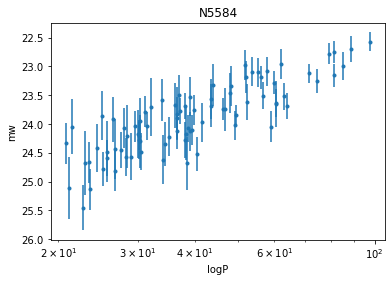

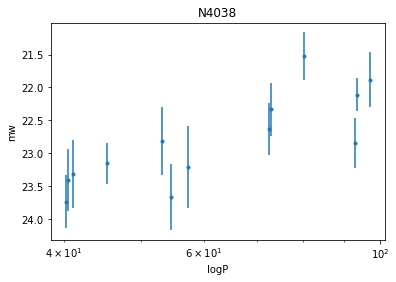

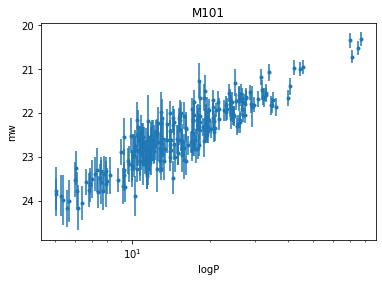

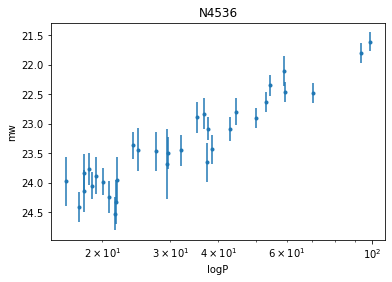

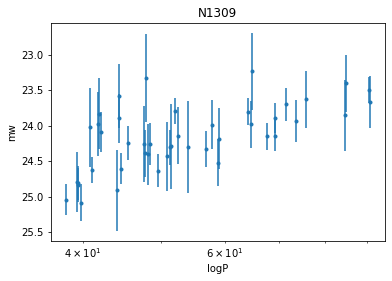

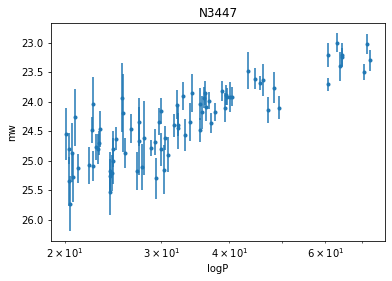

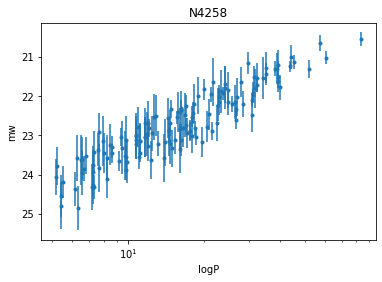

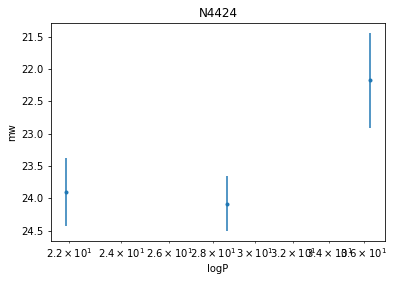

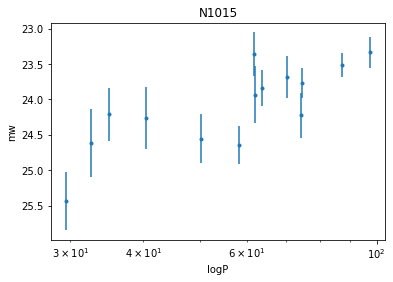

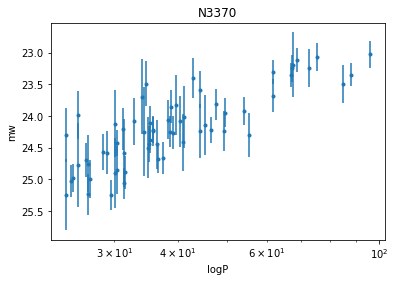

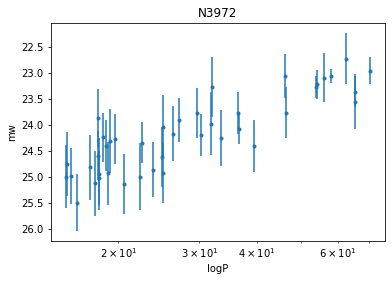

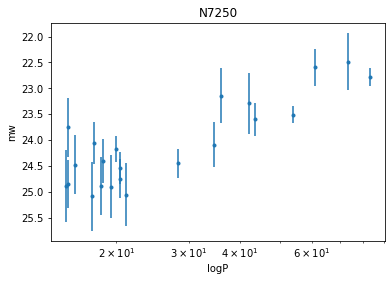

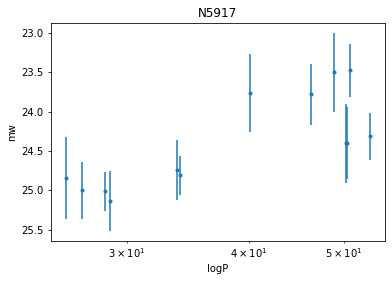

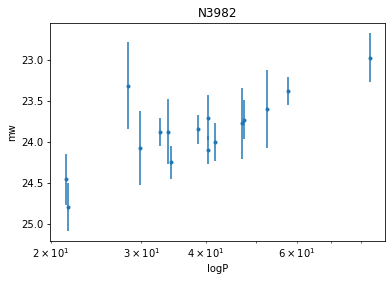

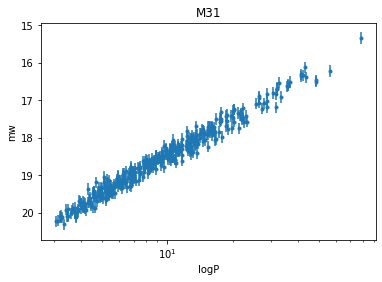

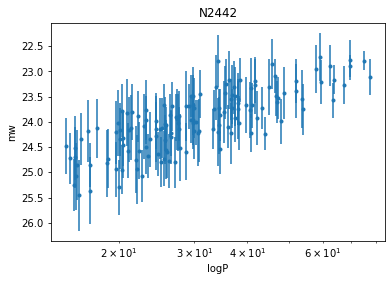

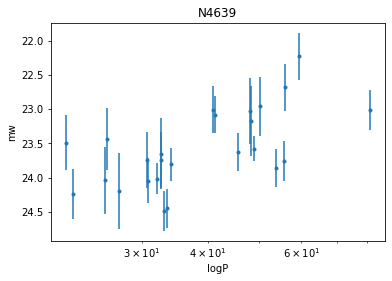

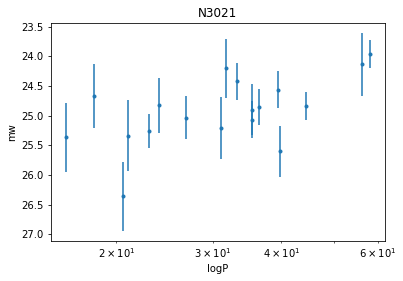

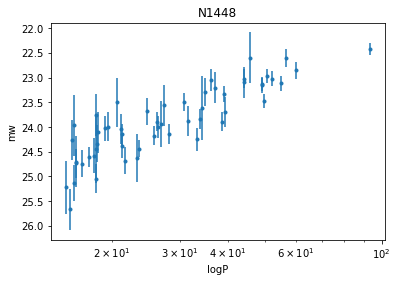

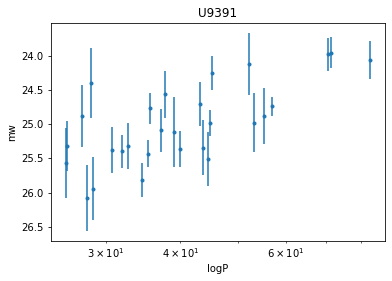

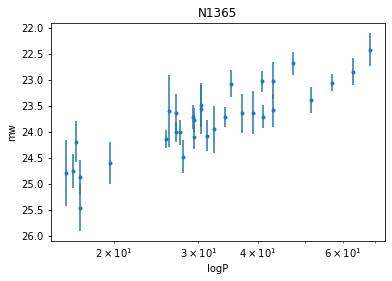

In [111]:
for host in host_list:
    cephe_list = data_cephe[data_cephe['Gal']== host]
    plt.figure()
    plt.title(host)
    plt.errorbar(cephe_list['Per'], cephe_list['mw'],yerr=cephe_list['sigTot'],fmt='.')
    plt.gca().invert_yaxis()
    plt.xscale('log')
    plt.xlabel('logP')
    plt.ylabel('mw')
plt.show()

### Fit without SN Ia and M31

In [266]:
data_woM31 = data_cephe[data_cephe['Gal'] != 'M31']

### Fit with one anchor : NGC 4258 

#### Simple slop

In [187]:
#res = mu_i-mu_4258, mu_M31-mu_4258, zpw4258, bw, Zw, m_4258
n_params = 5

############################
#SN HOST CEPHEIDS and SN Ia#
############################
n_ceph_by_host = [len(data_cephe[data_cephe['Gal']== host]) for host in sn_host]
n_ceph = np.sum(n_ceph_by_host)
n_ceph_cumsum = np.concatenate(([0],np.cumsum(n_ceph_by_host)))
n_sn = len(sn_host)
L_ceph = np.zeros((n_ceph,n_sn+n_params))
L_sn = np.zeros((n_sn,n_sn+n_params))
y_ceph=np.zeros(n_ceph)
y_sn = np.zeros(n_sn)
cov_ceph=np.zeros(n_ceph)
cov_sn=np.zeros(n_sn)

for i,host in enumerate(sn_host):
    selec_ceph = data_cephe[data_cephe['Gal']== host]
    
    n_ceph_host = n_ceph_by_host[i]
    L_ceph[n_ceph_cumsum[i]:n_ceph_cumsum[i+1],i] = 1
    L_ceph[n_ceph_cumsum[i]:n_ceph_cumsum[i+1],-4] = 1
    L_ceph[n_ceph_cumsum[i]:n_ceph_cumsum[i+1],-3] = np.log10(selec_ceph['Per'])
    L_ceph[n_ceph_cumsum[i]:n_ceph_cumsum[i+1],-2] = selec_ceph['[O/H]'] - 8.66
    
    L_sn[i,i] = 1 
    L_sn[i,-1] = 1
    
    y_ceph[n_ceph_cumsum[i]:n_ceph_cumsum[i+1]]= selec_ceph['mw']
    y_sn[i] = data_sn_R16[data_sn_R16['Gal'] == host]['mB'] 
    
    cov_ceph[n_ceph_cumsum[i]:n_ceph_cumsum[i+1]] = pw(selec_ceph['sigTot'],2)
    cov_sn[i] = pw(data_sn_R16[data_sn_R16['Gal'] == host]['sig_mB'],2) 

###################
#NGC 4258 CEPHEIDS#
###################
selec_ceph = data_cephe[data_cephe['Gal'] == 'N4258']
n_4258 = len(selec_ceph)
L_4258 = np.zeros((n_4258,n_sn+n_params))
L_4258[:,-4] = 1
L_4258[:,-3] = np.log10(selec_ceph['Per'])
L_4258[:,-2] = selec_ceph['[O/H]'] - 8.66

y_4258 = selec_ceph['mw']
cov_4258 = pw(selec_ceph['sigTot'],2) 

##############
#M31 CEPHEIDS#
##############
selec_ceph = data_cephe[data_cephe['Gal'] == 'M31']
n_M31 = len(selec_ceph)
L_M31 = np.zeros((n_M31,n_sn+n_params))
L_M31[:,-5] = 1
L_M31[:,-4] = 1
L_M31[:,-3] = np.log10(selec_ceph['Per'])
L_M31[:,-2] = selec_ceph['[O/H]'] - 8.66
y_M31 = selec_ceph['mw']
cov_M31 = pw(selec_ceph['sigTot'],2) 

In [188]:
L = np.concatenate((L_ceph, L_4258, L_M31, L_sn))
y = np.concatenate((y_ceph, y_4258, y_M31, y_sn))
C = np.diag(np.concatenate((cov_ceph, cov_4258, cov_M31, cov_sn)))
print(f"nbr cepheids = {len(y_ceph)+len(y_4258)+len(y_M31)}")

nbr cepheids = 1486


##### Fisher solution

In [189]:
C_inv = np.linalg.inv(C)
cov_res = np.linalg.inv(L.T @ C_inv @ L)
res = cov_res @ L.T @ C_inv @ y

In [190]:
print(res)
print(np.sqrt(np.diag(cov_res)))

[ 2.45644823  2.0544142  -0.18205252  1.57125476  3.17912111  2.57802559
  1.50243679  3.21725906  2.74580315  2.2996603   2.17667762  2.92811303
  2.34773247  2.18712562  2.23709799  3.07262779  1.99053714  3.54991998
  1.95725568 -4.88934561 26.64019044 -3.22895178 -0.16799866 10.07909727]
[0.04090233 0.08506417 0.03749589 0.04769967 0.04940515 0.03777816
 0.10939662 0.07103036 0.04421264 0.06221874 0.06914514 0.08213664
 0.06188691 0.04746441 0.06269095 0.07517995 0.04064125 0.05638962
 0.05325401 0.02885799 0.04272574 0.02346298 0.07484655 0.04117149]


In [191]:
log_H0 = (res[-1]-mu_N4258+5*av+25)/5
sigma_log_H0 = np.sqrt(25*pw(sigma_av,2)+pw(sigma_mu_N4258,2)+cov_res[-1,-1])/5
H0 = pw(10,log_H0)
sigma_H0 = np.log(10)*H0*sigma_log_H0
print(f"logH0 = {log_H0} +/- {sigma_log_H0}")
print(f"H0 = {H0} +/- {sigma_H0}")

logH0 = 1.8511494538887583 +/- 0.014140398831822248
H0 = 70.98219971918859 +/- 2.3111429129624232


##### Minuit $\chi^2$ minimization

In [167]:
def chi2_simp(q):
    return (y-L @ q).T @ C_inv @ (y-L.dot(q))

In [168]:
names = np.concatenate((np.array([n for n in sn_host]),np.array(['mu_M31-mu_4248', 'zpw4258', 'bw', 'Zw', 'm_4258'])))
chimin_simp = Minuit.from_array_func(chi2_simp, res, errordef = 1, error=0.001, name=names)

In [169]:
chimin_simp.migrad()
chimin_simp.hesse()
chimin_simp.minos()
print(chimin_simp.params)
print(f'chi2={chimin_simp.fval/(np.size(y)-np.size(res))}')

----------------------------------------------------------------------------------------------------
|   | Name           |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
----------------------------------------------------------------------------------------------------
| 0 | N5584          |   2.45    |   0.05    |   -0.05    |    0.05    |         |         |       |
| 1 | N4038          |   2.06    |   0.09    |   -0.09    |    0.09    |         |         |       |
| 2 | M101           |   -0.19   |   0.04    |   -0.04    |    0.04    |         |         |       |
| 3 | N4536          |   1.56    |   0.06    |   -0.06    |    0.06    |         |         |       |
| 4 | N1309          |   3.17    |   0.06    |   -0.06    |    0.06    |         |         |       |
| 5 | N3447          |   2.58    |   0.05    |   -0.05    |    0.05    |         |         |       |
| 6 | N4424          |   1.49    |   0.11    |   -0.11    |    0.11    |         |         

In [170]:
log_H0 = (chimin_simp.np_values()[-1]-mu_N4258+5*aB+25)/5
sigma_log_H0 = np.sqrt(25*pw(sigma_aB,2)+pw(sigma_mu_N4258,2)+cov_res[-1,-1])/5
H0 = pw(10,log_H0)
sigma_H0 = np.log(10)*pw(10,log_H0)*sigma_log_H0
print(f"logH0 = {log_H0} +/- {sigma_log_H0}")
print(f"H0 = {H0} +/- {sigma_H0}")

logH0 = 1.8532067761052495 +/- 0.01458746779170159
H0 = 71.31925142211666 +/- 2.3955341971859507


##### Fit results plot

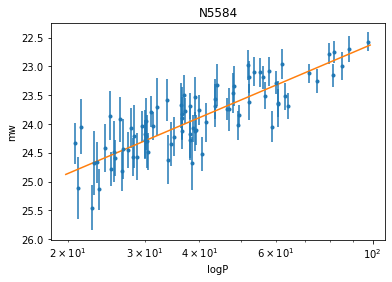

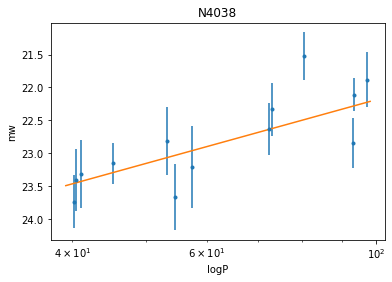

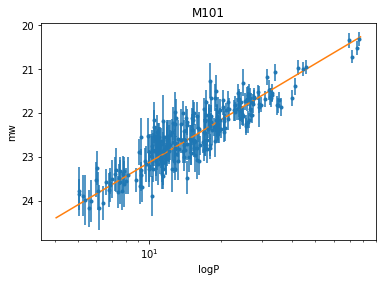

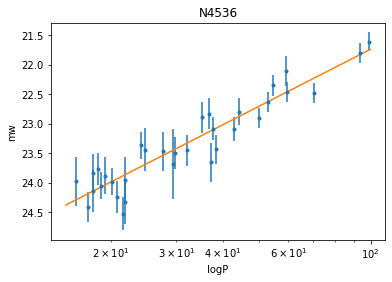

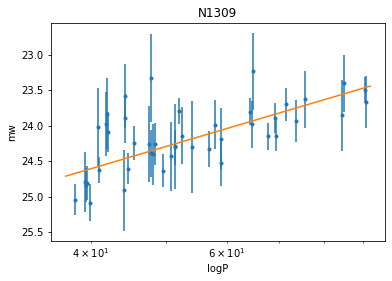

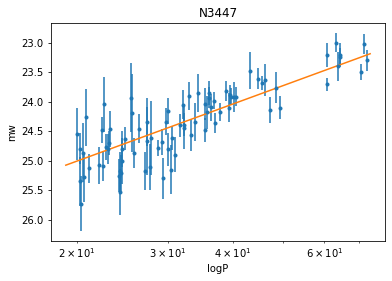

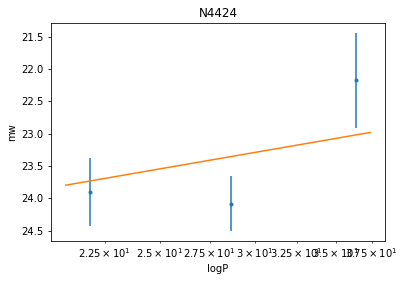

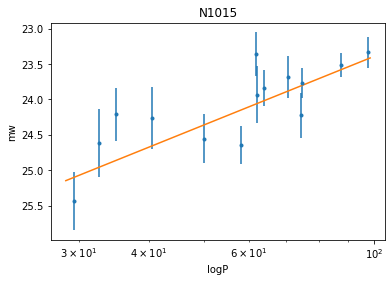

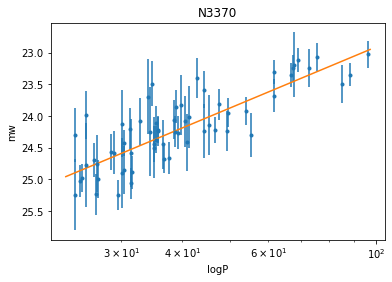

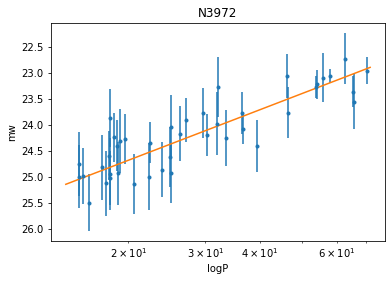

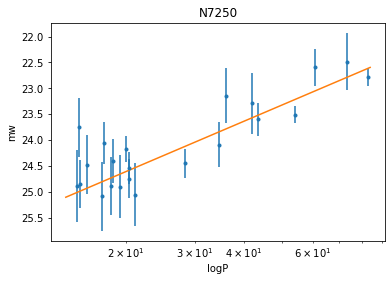

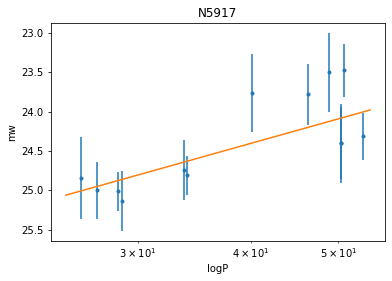

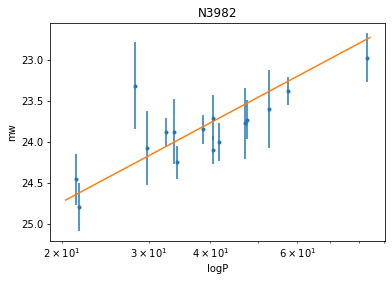

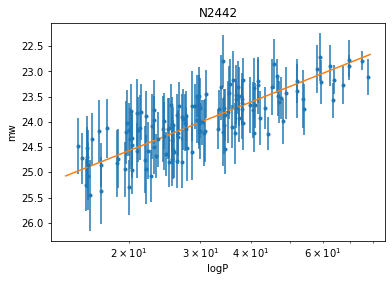

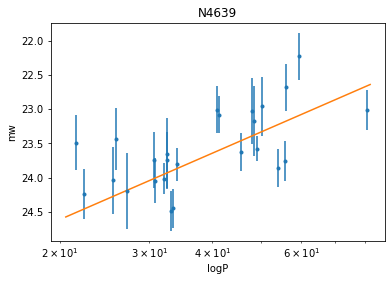

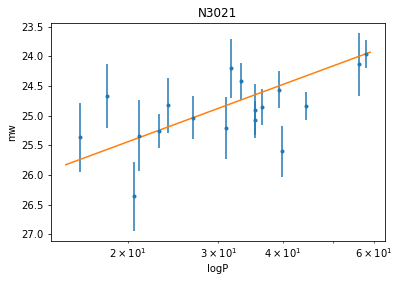

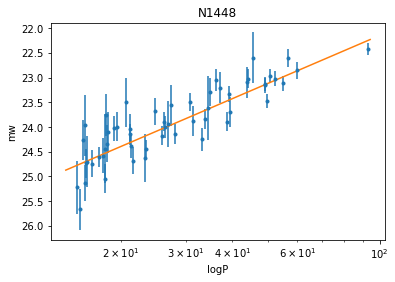

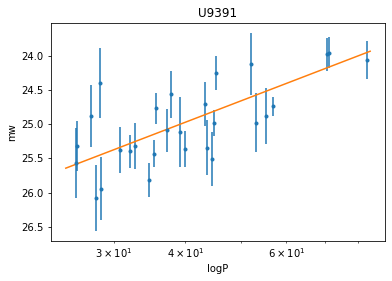

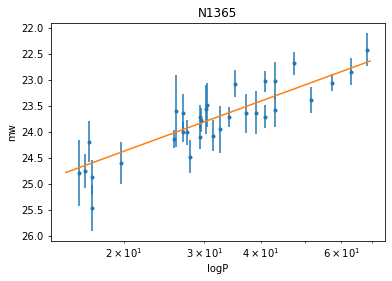

In [174]:
mu_mu4258_fit = chimin_simp.np_values()[:len(sn_host)]
zp = chimin_simp.np_values()[-4]
bw = chimin_simp.np_values()[-3]
zw = chimin_simp.np_values()[-2]
for host,i in zip(sn_host,np.arange(len(sn_host))):
    cephe_list = data_cephe[data_cephe['Gal']== host]
    plt.figure()
    plt.title(host)
    plt.errorbar(cephe_list['Per'], cephe_list['mw'],yerr=cephe_list['sigTot'],fmt='.')
    p = np.linspace(np.min(cephe_list['Per'])-1,np.max(cephe_list['Per'])+1,1000)
    plt.plot(p,mu_mu4258_fit[i]+zp+bw*np.log10(p)+zw*np.mean(cephe_list['[O/H]']-8.66))
    plt.gca().invert_yaxis()
    plt.xscale('log')
    plt.xlabel('logP')
    plt.ylabel('mw')
plt.show()

In [217]:
gal_riess= dict(M101=[29.135,0.045],
                N1015=[32.497,0.081],
                N1309=[32.523,0.055],
                N1365=[31.307,0.057],
                N1448=[31.311,0.045],
                N2442=[31.511,0.053],
                N3021=[32.498,0.090],
                N3370=[32.072,0.049],
                N3447=[31.908,0.043],
                N3972=[31.587,0.070],
                N3982=[31.737,0.069],
                N4038=[31.290,0.112],
                N4424=[31.080,0.292],
                N4536=[30.906,0.053],
                N4639=[31.532,0.071],
                N5584=[31.786,0.046],
                N5917=[32.263,0.102],
                N7250=[31.499,0.078],
                U9391=[32.919,0.063]) 

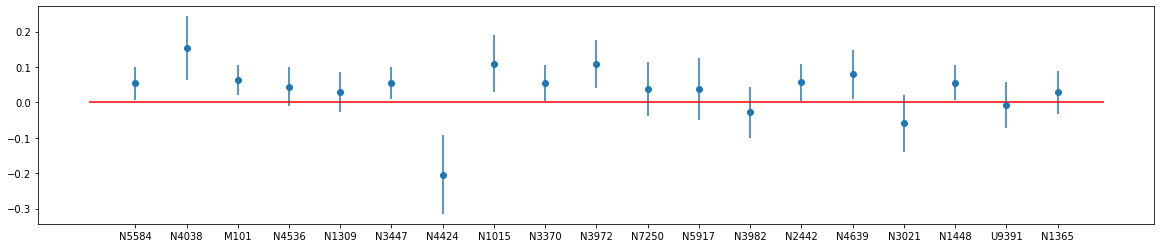

In [261]:
plt.figure(figsize=(20,4))
gals= set(data_sn_R16['Gal'])
mu_mu4258_R = np.array([data_sn_R16[data_sn_R16['Gal']==name]['mu_i'][0] - 29.387 for name in gals])
mu_mu4258_fit = chimin_simp.np_values()[:len(sn_host)]

err_fit = chimin_simp.np_errors()[:len(sn_host)]
plt.errorbar(np.arange(len(gals)),
          mu_mu4258_fit - mu_mu4258_R,
          yerr=err_fit,marker='o',ls='None')
plt.hlines(0,*xlim(),color='r')
plt.xticks(np.arange(len(gals)), gals)
plt.show()

#### Double slop

In [134]:
#res = mu_i-mu_4258, mu_M31-mu_4258, zpw4258, bw, bl, Zw, m_4258
n_params = 6

############################
#SN HOST CEPHEIDS and SN Ia#
############################
n_ceph_by_host = [len(data_cephe[data_cephe['Gal']== host]) for host in sn_host]
n_ceph = np.sum(n_ceph_by_host)
n_ceph_cumsum = np.concatenate(([0],np.cumsum(n_ceph_by_host)))
n_sn = len(sn_host)
L_ceph = np.zeros((n_ceph,n_sn+n_params))
L_sn = np.zeros((n_sn,n_sn+n_params))
y_ceph=np.zeros(n_ceph)
y_sn = np.zeros(n_sn)
cov_ceph=np.zeros(n_ceph)
cov_sn=np.zeros(n_sn)

for i,host in enumerate(sn_host):
    selec_ceph = data_cephe[data_cephe['Gal'] == host]
    P_sup10 = selec_ceph['Per'] > 10
    P_inf10 = [not bool for bool in P_sup10]
    L_ceph[n_ceph_cumsum[i]:n_ceph_cumsum[i+1],i] = 1
    L_ceph[n_ceph_cumsum[i]:n_ceph_cumsum[i+1],-5] = 1
    L_ceph[n_ceph_cumsum[i]:n_ceph_cumsum[i+1],-4] = np.log10(selec_ceph['Per'])*P_sup10
    L_ceph[n_ceph_cumsum[i]:n_ceph_cumsum[i+1],-3] = np.log10(selec_ceph['Per'])*P_inf10
    L_ceph[n_ceph_cumsum[i]:n_ceph_cumsum[i+1],-2] = selec_ceph['[O/H]'] - 8.9
 
    L_sn[i,i] = 1
    L_sn[i,-1] = 1
    
    y_ceph[n_ceph_cumsum[i]:n_ceph_cumsum[i+1]] = selec_ceph['mw']
    y_sn[i] = data_sn_R16[data_sn_R16['Gal'] == host]['mB']
    
    cov_ceph[n_ceph_cumsum[i]:n_ceph_cumsum[i+1]] = pw(selec_ceph['sigTot'],2)
    cov_sn[i] = pw(data_sn_R16[data_sn_R16['Gal'] == host]['sig_mB'],2)

###################
#NGC 4258 CEPHEIDS#
###################
selec_ceph = data_cephe[data_cephe['Gal'] == 'N4258']
n_4258 = len(selec_ceph)
L_4258 = np.zeros((n_4258,n_sn+n_params))
P_sup10 = selec_ceph['Per'] > 10
P_inf10 = [not bool for bool in P_sup10]
L_4258[:,-5] = 1
L_4258[:,-4] = np.log10(selec_ceph['Per'])*P_sup10
L_4258[:,-3] = np.log10(selec_ceph['Per'])*P_inf10
L_4258[:,-2] = selec_ceph['[O/H]'] - 8.66

y_4258 = selec_ceph['mw']
cov_4258 = pw(selec_ceph['sigTot'],2)
  
##############
#M31 CEPHEIDS#
##############
selec_ceph = data_cephe[data_cephe['Gal'] == 'M31']
n_M31 = len(selec_ceph)
L_M31 = np.zeros((n_M31,n_sn+n_params))
P_sup10 = selec_ceph['Per'] > 10
P_inf10 = [not bool for bool in P_sup10]
L_M31[:,-6] = 1
L_M31[:,-5] = 1
L_M31[:,-4] = np.log10(selec_ceph['Per'])*P_sup10
L_M31[:,-3] = np.log10(selec_ceph['Per'])*P_inf10
L_M31[:,-2] = selec_ceph['[O/H]'] - 8.66

y_M31 = selec_ceph['mw']
cov_M31 = pw(selec_ceph['sigTot'],2)



In [135]:
L = np.concatenate((L_ceph, L_4258, L_M31, L_sn))
y = np.concatenate((y_ceph, y_4258, y_M31, y_sn))
C = np.diag(np.concatenate((cov_ceph, cov_4258, cov_M31, cov_sn)))

##### Fisher solution

In [136]:
C_inv = np.linalg.inv(C)
cov_res = np.linalg.inv(L.T @ C_inv @ L)
res = cov_res @ L.T @ C_inv @ y

chi2 = ((y-L @ res).T @ C_inv @ (y-L @ res))/(np.size(y)-np.size(res))

In [137]:
print(res)
print(f'chi2 = {chi2}')

[ 2.41689462  2.01505731 -0.22275199  1.5314352   3.13978282  2.53812762
  1.46254603  3.17810221  2.70611413  2.25976814  2.13676176  2.88823003
  2.3079053   2.14706369  2.19729291  3.03265117  1.95055425  3.51023431
  1.91720232 -4.88921927 26.64621808 -3.23302465 -3.23815432 -0.16796837
 10.11890768]
chi2 = 1.0754227473556168


In [138]:
log_H0 = (res[-1]-mu_N4258+5*av+25)/5
sigma_log_H0 = np.sqrt(25*pw(sigma_av,2)+pw(sigma_mu_N4258,2)+cov_res[-1,-1])/5
H0 = pw(10,log_H0)
sigma_H0 = np.log(10)*pw(10,log_H0)*sigma_log_H0
print(f"logH0 = {log_H0} +/- {sigma_log_H0}")
print(f"H0 = {H0} +/- {sigma_H0}")

logH0 = 1.8591115367660485 +/- 0.014719464495959894
H0 = 72.29554512736885 +/- 2.450299863481651


##### Minuit $\chi^2$ minimization

In [139]:
def chi2_doub(q):
    return (y-L @ q).T @ C_inv @ (y-L.dot(q))

In [141]:
names = np.concatenate((np.array(["mu_{}_muN4258".format(n) for n in sn_host]),np.array(['mu_M31-mu_4248', 'zpw4258', 'bw', 'bl', 'Zw', 'm_4258'])))
chimin_doub = Minuit.from_array_func(chi2_simp, res, errordef = 1, error=0.001, name=names)

In [142]:
chimin_doub.migrad()
chimin_doub.hesse()
chimin_doub.minos()
print(chimin_doub.params)
print(f'chi2={chimin_doub.fval/(np.size(y)-np.size(res))}')

------------------------------------------------------------------------------------------------------
|   | Name             |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------------------
| 0 | mu_N5584_muN4258 |   2.42    |   0.05    |   -0.05    |    0.05    |         |         |       |
| 1 | mu_N4038_muN4258 |   2.02    |   0.09    |   -0.09    |    0.09    |         |         |       |
| 2 | mu_M101_muN4258  |  -0.223   |   0.031   |   -0.031   |   0.031    |         |         |       |
| 3 | mu_N4536_muN4258 |   1.53    |   0.05    |   -0.05    |    0.05    |         |         |       |
| 4 | mu_N1309_muN4258 |   3.14    |   0.05    |   -0.05    |    0.05    |         |         |       |
| 5 | mu_N3447_muN4258 |   2.54    |   0.05    |   -0.05    |    0.05    |         |         |       |
| 6 | mu_N4424_muN4258 |   1.46    |   0.11    |   -0.11    |    0.11    

In [150]:
log_H0 = (chimin_doub.np_values()[-1]-mu_N4258+5*aB+25.)/5.
sigma_log_H0 = np.sqrt(25*pw(sigma_av,2)+pw(sigma_mu_N4258,2)+cov_res[-2,-2])/5
H0 = pw(10,log_H0)
sigma_H0 = np.log(10)*pw(10,log_H0)*sigma_log_H0
print(f"logH0 = {log_H0} +/- {sigma_log_H0}")
print(f"H0 = {H0} +/- {sigma_H0}")

logH0 = 1.8591115367660485 +/- 0.018874008440919875
H0 = 72.29554512736885 +/- 3.141892853427587


#### Fit results plot

In [ ]:
mu_mu4258_fit = res[:n_sn]
zp = res[-5]
bw = res[-4]
zw = res[-2]
for host,i in zip(sn_host,np.arange(len(sn_host))):
    cephe_list = data_cephe[data_cephe['Field'] == host]
    plt.figure()
    plt.title(host)
    plt.errorbar(cephe_list['Per'], cephe_list['F160W']-R*cephe_list['F555W-F814W'],yerr=cephe_list['sigma_tot'],fmt='.')
    p = np.linspace(np.min(cephe_list['Per'])-1,np.max(cephe_list['Per'])+1,1000)
    plt.plot(p,mu_mu4258_fit[i]+zp+bw*np.log10(p)+zw*(np.mean(cephe_list['[O/H]'])))
    plt.gca().invert_yaxis()
    plt.xscale('log')
    plt.xlabel('logP')
    plt.ylabel('mw')
cephe_list = data_cephe[data_cephe['Field'] == b'M31']
plt.figure()
plt.title('M31')
plt.errorbar(cephe_list['Per'], cephe_list['F160W']-R*cephe_list['F555W-F814W'],yerr=cephe_list['sigma_tot'],fmt='.')
p = np.linspace(np.min(cephe_list['Per'])-1,np.max(cephe_list['Per'])+1,1000)
plt.plot(p,res[-6]+bw*np.log10(p)+zw*(np.mean(cephe_list['[O/H]'])))
plt.gca().invert_yaxis()
plt.xscale('log')
plt.xlabel('logP')
plt.ylabel('mw')
plt.show()

## Fit with 3 anchors - Work in progress

In [ ]:
#res = mu_i, Delta_mu4258, MW_H, Delta_muLMC, mu_M31, bw, bl, MB0, Zw, Delta_zp
n_params = 10

########################
#Ceph and SN in SN HOST#
########################

n_ceph_by_host = [len(data_cephe[data_cephe['Field']== host]) for host in sn_host]
n_ceph = np.sum(n_ceph_by_host)
n_ceph_cumsum = np.concatenate(([0],np.cumsum(n_ceph_by_host)))
n_sn = len(sn_host)
L_ceph = np.zeros((n_ceph,n_sn+n_params))
L_sn = np.zeros((n_sn,n_sn+n_params))
y_ceph=np.zeros(n_ceph)
y_sn = np.zeros(n_sn)
cov_ceph=np.zeros(n_ceph)
cov_sn=np.zeros(n_sn)

for i,host in enumerate(sn_host):
    selec_ceph = data_cephe[data_cephe['Field'] == host]
    P_sup10 = selec_ceph['Per'] > 10
    P_inf10 = [not bool for bool in P_sup10]
    L_ceph[n_ceph_cumsum[i]:n_ceph_cumsum[i+1],i] = 1
    L_ceph[n_ceph_cumsum[i]:n_ceph_cumsum[i+1],-8] = 1
    L_ceph[n_ceph_cumsum[i]:n_ceph_cumsum[i+1],-5] = np.log10(selec_ceph['Per'])*P_sup10
    L_ceph[n_ceph_cumsum[i]:n_ceph_cumsum[i+1],-4] = np.log10(selec_ceph['Per'])*P_inf10
    L_ceph[n_ceph_cumsum[i]:n_ceph_cumsum[i+1],-2] = selec_ceph['[O/H]'] 
 
    L_sn[i,i] = 1
    L_sn[i,-3] = 1
    
    y_ceph[n_ceph_cumsum[i]:n_ceph_cumsum[i+1]] = selec_ceph['F160W']-R*selec_ceph['F555W-F814W']
    y_sn[i] = data_sn[data_sn['Field'] == host]['mag_5a'] - 5*av
    
    cov_ceph[n_ceph_cumsum[i]:n_ceph_cumsum[i+1]] = pw(selec_ceph['sigma_tot'],2)
    cov_sn[i] = pw(data_sn[data_sn['Field'] == host]['sigma_mag_5a'],2)-25*pw(sigma_av,2)
    
y_4258 = selec_ceph['F160W']-R*selec_ceph['F555W-F814W']
cov_4258 = pw(selec_ceph['sigma_tot'],2)


In [ ]:
##################
#Ceph in NGC 4258#
##################

selec_ceph = data_cephe[data_cephe['Field']== b'N4258']
n_4258 = len(selec_ceph)
L_4258 = np.zeros((n_4258,n_sn+n_params))
P_sup10 = selec_ceph['Per'] > 10
P_inf10 = [not bool for bool in P_sup10]
L_4258[:,-9] = 1
L_4258[:,-5] = np.log10(selec_ceph['Per'])*P_sup10
L_4258[:,-4] = np.log10(selec_ceph['Per'])*P_inf10
L_4258[:,-1] = selec_ceph['[O/H]'] 

y_4258 = selec_ceph['F160W']-R*selec_ceph['F555W-F814W']-mu_N4258
cov_4258 = pw(selec_ceph['sigma_tot'],2)+pw(sigma_mu_N4258,2)

In [ ]:
#############
#Ceph in M31#
#############

selec_ceph = data_cephe[data_cephe['Field']== b'M31']
n_M31 = len(selec_ceph)
L_M31 = np.zeros((n_M31,n_sn+n_params))
P_sup10 = selec_ceph['Per'] > 10
P_inf10 = [not bool for bool in P_sup10]
L_M31[:,-6] = 1
L_M31[:,-8] = 1
L_M31[:,-5] = np.log10(selec_ceph['Per'])*P_sup10
L_M31[:,-4] = np.log10(selec_ceph['Per'])*P_inf10
L_M31[:,-2] = selec_ceph['[O/H]'] 

y_M31 = selec_ceph['F160W']-R*selec_ceph['F555W-F814W']
cov_M31 = pw(selec_ceph['sigma_tot'],2)


L = np.concatenate((L_ceph,L_sn),axis=0)
y = np.concatenate((y_ceph,y_sn))
C = np.diag(np.concatenate((cov_ceph,cov_sn)))

In [ ]:
############
#Ceph in MW#
############

selec_ceph = data_cephe[data_cephe['Field']== b'MW']
n_MW = len(selec_ceph)
L_MW = np.zeros((n_MW,n_sn+n_params))
P_sup10 = selec_ceph['Per'] > 10
P_inf10 = [not bool for bool in P_sup10]
L_MW[:,-6] = 1
L_MW[:,-8] = 1
L_MW[:,-5] = np.log10(selec_ceph['Per'])*P_sup10
L_MW[:,-4] = np.log10(selec_ceph['Per'])*P_inf10
L_MW[:,-2] = selec_ceph['[O/H]'] 

y_MW = selec_ceph['F160W']-R*selec_ceph['F555W-F814W']
cov_MW = pw(selec_ceph['sigma_tot'],2)
